**Introduction to the Rune Alphabet Prediction Project**

The Rune Alphabet Prediction project is an exciting exploration into the world of ancient scripts and modern machine learning. Runes are ancient alphabets used by Germanic tribes, and each rune symbol carries unique meanings and historical significance. This project aims to build a machine learning model capable of recognizing and classifying rune symbols from images, bridging the gap between ancient wisdom and cutting-edge technology.

**Objective**

The primary goal of this project is to create a Convolutional Neural Network (CNN) model that can accurately predict the type of rune symbol from an input image. By leveraging a dataset of rune images, the model will learn to distinguish between different rune letters, such as Fehu, Uruz, Ansuz, and others.

**Dataset**

The dataset used for this project is sourced from Kaggle and is titled "Enigmatic Runes: Gateway to Ancient Wisdom". It contains a collection of rune images, each labeled with its corresponding rune letter. The dataset is organized in a structured format, making it ideal for training and evaluating machine learning models.

Dataset Link: https://www.kaggle.com/datasets/johnrem/enigmatic-runes-gateway-to-ancient-wisdom


In [1]:
# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import os
from sklearn.model_selection import train_test_split

Download Kaggle Dataset

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("johnrem/enigmatic-runes-gateway-to-ancient-wisdom")

print("Path to dataset files:", path)

100%|██████████| 140M/140M [00:04<00:00, 30.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/johnrem/enigmatic-runes-gateway-to-ancient-wisdom/versions/1


Dataset Path

In [3]:
dataset_path = '/root/.cache/kagglehub/datasets/johnrem/enigmatic-runes-gateway-to-ancient-wisdom/versions/1/elder_futhark'

Define transformations for data augmentation and normalization

In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomRotation(10),  # Randomly rotate images by up to 10 degrees
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet stats
])

Load the dataset using ImageFolder

In [5]:
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

Split the dataset into training, validation, and test sets

In [6]:
train_size = int(0.8 * len(full_dataset))  # 80% for training
val_size = int(0.1 * len(full_dataset))  # 10% for validation
test_size = len(full_dataset) - train_size - val_size  # 10% for testing

In [7]:
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size, test_size])

Data loaders

In [8]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Define the model

In [9]:
# Load a pretrained ResNet18 model and modify the final layer
model = models.resnet18(pretrained=True)
num_classes = len(full_dataset.classes)  # Number of rune letters
model.fc = nn.Linear(model.fc.in_features, num_classes)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 134MB/s]


Define loss function and optimizer

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Train the model

In [11]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

Epoch [1/10], Loss: 0.6441
Epoch [2/10], Loss: 0.0869
Epoch [3/10], Loss: 0.0455
Epoch [4/10], Loss: 0.1229
Epoch [5/10], Loss: 0.0609
Epoch [6/10], Loss: 0.0631
Epoch [7/10], Loss: 0.0374
Epoch [8/10], Loss: 0.0428
Epoch [9/10], Loss: 0.0537
Epoch [10/10], Loss: 0.1259


Evaluate the model on the validation set

In [12]:

model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Validation Accuracy: {accuracy:.2f}%")

Validation Accuracy: 92.15%


Test the model on the test set

In [13]:

model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 93.69%


Save the model

In [14]:

torch.save(model.state_dict(), 'rune_classifier.pth')
print("Model saved as 'rune_classifier.pth'")

Model saved as 'rune_classifier.pth'


## Code to Test the Model on a Single Image

In [25]:
%ls /root/.cache/kagglehub/datasets/johnrem/enigmatic-runes-gateway-to-ancient-wisdom/versions/1/elder_futhark/kennaz/IMG_20240326_232312.jpg

IMG_20240326_232027.jpg  IMG_20240326_232114.jpg  IMG_20240326_232216.jpg  IMG_20240326_232314.jpg
IMG_20240326_232028.jpg  IMG_20240326_232117.jpg  IMG_20240326_232218.jpg  IMG_20240326_232318.jpg
IMG_20240326_232032.jpg  IMG_20240326_232119.jpg  IMG_20240326_232221.jpg  IMG_20240326_232320.jpg
IMG_20240326_232034.jpg  IMG_20240326_232121.jpg  IMG_20240326_232222.jpg  IMG_20240326_232323.jpg
IMG_20240326_232035.jpg  IMG_20240326_232124.jpg  IMG_20240326_232226.jpg  IMG_20240326_232327.jpg
IMG_20240326_232039.jpg  IMG_20240326_232126.jpg  IMG_20240326_232228.jpg  IMG_20240326_232329.jpg
IMG_20240326_232040.jpg  IMG_20240326_232129.jpg  IMG_20240326_232230.jpg  IMG_20240326_232331.jpg
IMG_20240326_232042.jpg  IMG_20240326_232131.jpg  IMG_20240326_232232.jpg  IMG_20240326_232333.jpg
IMG_20240326_232044.jpg  IMG_20240326_232133.jpg  IMG_20240326_232238.jpg  IMG_20240326_232337.jpg
IMG_20240326_232047.jpg  IMG_20240326_232137.jpg  IMG_20240326_232240.jpg  IMG_20240326_232339.jpg
IMG_202403

In [18]:
from PIL import Image
import matplotlib.pyplot as plt

# Step 1: Load the trained model
# Define the model architecture (must match the one used during training)
model = models.resnet18(pretrained=False)
num_classes = len(full_dataset.classes)  # Number of rune letters
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Load the saved model weights
model.load_state_dict(torch.load('rune_classifier.pth'))
model.eval()  # Set the model to evaluation mode

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-18-7647bca3d9d0>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [19]:
# Move the model to the appropriate device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [20]:
# Step 2: Load and preprocess the test image
def preprocess_image(image_path):
    # Define the same transformations used during training
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to match the input size of the model
        transforms.ToTensor(),  # Convert to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
    ])

    # Load the image
    image = Image.open(image_path).convert('RGB')  # Ensure the image is in RGB format
    image = transform(image).unsqueeze(0)  # Add a batch dimension
    return image

In [21]:
# Step 3: Make a prediction
def predict(image_path, model, class_names):
    # Preprocess the image
    image = preprocess_image(image_path).to(device)

    # Make a prediction
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
        predicted_class = class_names[predicted.item()]

    return predicted_class

In [22]:
# Step 4: Display the image and prediction
def show_prediction(image_path, predicted_class):
    # Load the image
    image = Image.open(image_path)

    # Display the image
    plt.imshow(image)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()

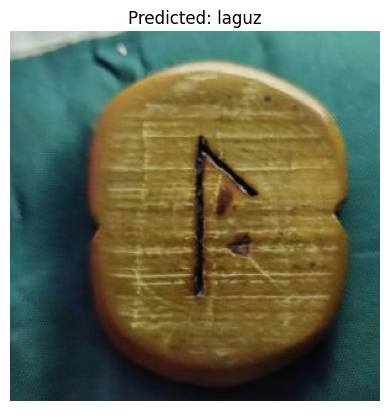

In [23]:

# Step 5: Test the model on an image from the test set
# Get the class names from the dataset
class_names = full_dataset.classes

# Choose an image from the test set (replace with the path to your test image)
test_image_path = '/root/.cache/kagglehub/datasets/johnrem/enigmatic-runes-gateway-to-ancient-wisdom/versions/1/elder_futhark/laguz/IMG_20240327_141652.jpg'  # Update this path

# Make a prediction
predicted_class = predict(test_image_path, model, class_names)

# Display the result
show_prediction(test_image_path, predicted_class)

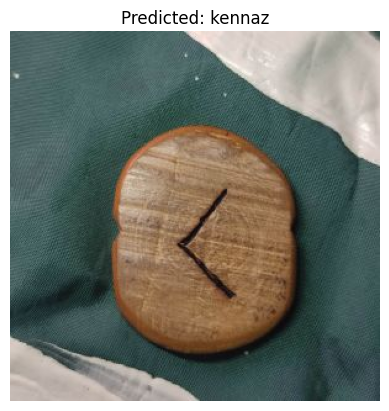

In [26]:

# Step 5: Test the model on an image from the test set
# Get the class names from the dataset
class_names = full_dataset.classes

# Choose an image from the test set (replace with the path to your test image)
test_image_path = '/root/.cache/kagglehub/datasets/johnrem/enigmatic-runes-gateway-to-ancient-wisdom/versions/1/elder_futhark/kennaz/IMG_20240326_232312.jpg'  # Update this path

# Make a prediction
predicted_class = predict(test_image_path, model, class_names)

# Display the result
show_prediction(test_image_path, predicted_class)